For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7                                                                                                               
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/overview                                                       
dataset from                                                                                                                  
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
from PIL import Image
import PIL

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# import cv2
import glob

from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device
    
device

device(type='cuda')

In [55]:
train_path = 'D:\\lungs\\train-jpegs'
csv_path = 'E:\\Download\\new_downloads\\train.csv'

In [4]:
df_train = pd.read_csv(csv_path)

In [5]:
df_train.shape

(1790594, 17)

In [6]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [8]:
image_level_features = ['pe_present_on_image']
# exam_level_features = ['negative_exam_for_pe', 
exam_level_features = ['indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe', 'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',]
informational_features = ['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [9]:
label_0_fraction = 1.7

In [10]:
df_train.loc[df_train['pe_present_on_image'] == 0, exam_level_features] = 0
df_train[df_train.pe_present_on_image == 1].shape[0], df_train[df_train.pe_present_on_image == 0].shape[0], df_train[df_train.pe_present_on_image == 1].shape[0]/df_train[df_train.pe_present_on_image == 0].shape[0] # high inbalance

train_df_0 = df_train[df_train.pe_present_on_image == 0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*label_0_fraction), replace=False)
train_df_1 = df_train[df_train.pe_present_on_image == 1].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*0.8), replace=False)

In [11]:
train_df = train_df_0.append(train_df_1, ignore_index=False)

In [12]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
63429,11d79469b0a7,ec773d9c1e49,d8f7bd082812,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1583591,852c7b72ac38,19f33b2223b1,edfe722a697a,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1529092,20e5ca8a54ac,c4610c10316c,bb34d12f7c4d,0,1,0,0,0,0,0,0,0,0,0,0,0,0
382061,11259ba7fff5,245f5cf1e413,4e4256e8cf42,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1145941,95333fd514f5,09a838b7ea21,a65ec604156d,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613174,f818d30f0716,6b22adfbbdb9,063d4a5ae430,1,0,0,0,0,1,0,1,0,0,1,0,0,0
379606,7877d884e67c,be4831153f07,4b71326aff45,1,0,0,0,0,0,1,0,0,0,1,0,0,0
68164,60bc0d5537da,9835779f9b59,4895689d2e02,1,0,0,0,0,0,1,1,0,0,1,0,0,0
1133176,cd95b88a0b70,e9bc05c07d38,2bc1610bc34d,1,0,0,0,0,1,0,1,0,0,1,0,0,0


In [13]:
df_train = df_train.drop(train_df.index)

In [14]:
# df_train[df_train.pe_present_on_image==1]
val_df = df_train[df_train.pe_present_on_image==1].append(df_train[df_train.pe_present_on_image==0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*2.5), replace=False))

In [15]:
val_df = val_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [16]:
del df_train

In [17]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,2c22d6b87155,f9229b339c24,06af91a2e1da,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,d66cb1aac87b,9573d2dea6aa,dca0fffe80cd,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,a000a6f3cf65,60d5ad710306,083b493d2256,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,a2aa26d2fb25,a25aa88b7580,9d373cbc4d62,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4610db0aae36,669c491096e7,62babda85a95,1,0,0,0,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241345,2ec0ba1236ba,71dbb891c680,1e702ee66ce7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241346,daae29374b59,4d819d7b8a92,e47fdbb9adf1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
241347,d78c8eff9113,b0f221a46e41,655457140e40,1,0,0,0,0,0,1,1,0,0,1,0,0,0
241348,bf50df197564,2bc858584a3b,cfdce52518d8,1,0,0,0,0,1,0,0,0,0,1,0,0,0


In [18]:
val_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,d87a0b731924,33d1f7d9eb1f,9a7e86ac71fb,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,91f93d899e97,451d719782ec,c7006b85bc47,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,e63908b8788e,337613cf72da,734fc013f275,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,ffc9074f0679,931846ff5bf7,fe838d263e91,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,251340310050,05fa0600e697,b73a45486fdc,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67573,94aca278cc06,81167f99a846,f429b2afc349,1,0,0,0,0,0,1,1,0,0,1,0,0,0
67574,14c57dc12f12,ee9efe094804,4240fab3fc23,1,0,0,0,0,1,0,1,0,0,1,0,1,0
67575,a40ac7805066,30c8d2788d0a,15efb0eeacd2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67576,5c158d5b1865,346c407992ca,09f871fc0960,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
def get_an_image(df, idx=0):
    row = df.iloc[idx]
    img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    return img

In [20]:
img = get_an_image(train_df, 0)

In [21]:
np.array(img).shape

(256, 256, 3)

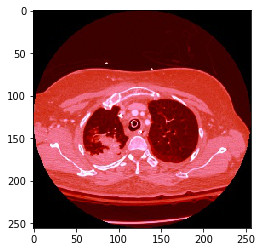

In [22]:
plt.imshow(img)

In [23]:
def plot_image(img):
    plt.figure(figsize=[12,6])
    plt.subplot(131)
    plt.imshow(img[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(img[:,:,2],cmap='gray')

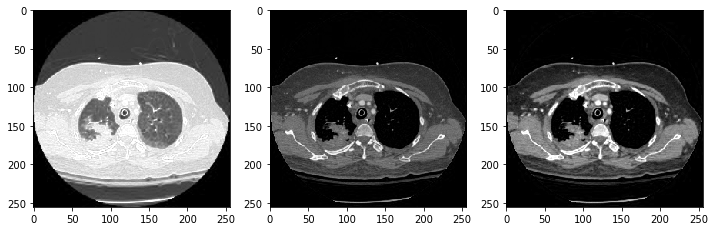

In [24]:
plot_image(np.array(img))

In [25]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        row = self.csv_file.iloc[idx]
        img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])

        img = self.transform(img).to(device)
        targets = torch.tensor(row[image_level_features+exam_level_features + informational_features].values.astype(np.float16)).float().to(device)

        return img, targets

In [26]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
#                                 transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224, 224)),
#                                 '''
#                                 7.4 - Dataset Augmentation
#                                 '''
                                transforms.RandomApply([ 
                                    transforms.ColorJitter(hue=.05, saturation=.05,),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)],p=0.3),
                                transforms.ToTensor(),
                                normalize
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [27]:
train_dataset = LungsDataset(train_df, transform=ds_trans)

val_dataset = LungsDataset(val_df, transform=ds_trans)

len(train_dataset), len(val_dataset)

(241350, 67578)

In [29]:
batch_size = 48
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [31]:
resnet101 = models.resnet50()
fc_feat_size = resnet101.fc.in_features
resnet101.fc.in_features, resnet101.fc.out_features

(2048, 1000)

In [32]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def __forward__(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [33]:
resnet101.avgpool = Identity()
resnet101.fc = Identity()

In [34]:
resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
fc_feat_size

2048

In [36]:
# 7.7 - Multi-Task Learning
def weights_init(m):
    classname = m.__class__.__name__
    for l in m.modules():
        if isinstance(l, nn.Conv2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.Linear):
            torch.nn.init.xavier_normal_(l.weight)
        
class MultiTaskHead(nn.Module):
    def __init__(self):
        super(MultiTaskHead, self).__init__()
        self.m = nn.Sequential(
                nn.Conv2d(2048, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )
        self.l = nn.Sequential(
                nn.Linear(fc_feat_size, fc_feat_size, bias=True), 
            # 7.12 - Dropout
                nn.Dropout(),
                nn.ReLU(),
                nn.Linear(fc_feat_size, 1024, bias=True), 
                nn.Dropout(),
                nn.Linear(1024, 512, bias=True), 
                nn.Dropout(),
                nn.Linear(512, 1), 
#                 nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 2048, int(np.sqrt(x.shape[1]/2048)), int(np.sqrt(x.shape[1]/2048)))
        x = self.m(x)
        x = self.l(x.squeeze())
        return x

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        self.stage = 'train'
        
        self.backbone = pretrained_model
        '''
        image-level feature
        '''
        self.linear_pe_present_on_image = MultiTaskHead()
        weights_init(self.linear_pe_present_on_image)
        '''
        exam-level features
        '''
        self.linear_negative_exam_for_pe = MultiTaskHead()
        weights_init(self.linear_negative_exam_for_pe)
        
        self.linear_indeterminate = MultiTaskHead()
        weights_init(self.linear_indeterminate)
        
        self.linear_chronic_pe = MultiTaskHead()
        weights_init(self.linear_chronic_pe)
        
        self.linear_acute_and_chronic_pe = MultiTaskHead()
        weights_init(self.linear_acute_and_chronic_pe)
        
        self.linear_central_pe = MultiTaskHead()
        weights_init(self.linear_central_pe)
        
        self.linear_leftsided_pe = MultiTaskHead()
        weights_init(self.linear_leftsided_pe)
        
        self.linear_rightsided_pe = MultiTaskHead()
        weights_init(self.linear_rightsided_pe)
        
        self.linear_rv_lv_ratio_gte_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_gte_1)
        
        self.linear_rv_lv_ratio_lt_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_lt_1)
        
        '''
        informational features
        '''
        self.linear_qa_motion = MultiTaskHead()
        weights_init(self.linear_qa_motion)
        
        self.linear_qa_contrast = MultiTaskHead()
        weights_init(self.linear_qa_contrast)
                
        self.linear_true_filling_defect_not_pe = MultiTaskHead()
        weights_init(self.linear_true_filling_defect_not_pe)
        
        self.linear_flow_artifact = MultiTaskHead()
        weights_init(self.linear_flow_artifact)

    def forward(self, x):
#         if self.stage == 'train':
#             x, _ = self.backbone(x)
#         else: 
        x = self.backbone(x)
        
#         print('x1 .shape', x1.shape)
        x_pe_present_on_image = self.linear_pe_present_on_image(x)
        
        x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x)
        x_indeterminate = self.linear_indeterminate(x)
        x_chronic_pe = self.linear_chronic_pe(x)
        x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x)
        x_central_pe = self.linear_central_pe(x)
        x_leftsided_pe = self.linear_leftsided_pe(x)
        x_rightsided_pe = self.linear_rightsided_pe(x)
        x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x)
        x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x)
        
        x_qa_motion = self.linear_qa_motion(x)
        x_qa_contrast = self.linear_qa_contrast(x)
        x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x)
        x_flow_artifact = self.linear_flow_artifact(x)
        
#         ys = []
#         for y_pred in [ x_pe_present_on_image, x_negative_exam_for_pe, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
#             ys.append(y_pred)
        ys = []
        for y_pred in [ x_pe_present_on_image, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
            ys.append(y_pred)
        return torch.cat(ys, 1)
                      

model = WrapperModel(resnet101).to(device)

In [37]:
model

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [38]:
for name, param in model.named_parameters():
#     if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('backbone.Mixed_') or name.startswith('linear')):
    if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('linear')):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [39]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [40]:
criterion = nn.BCEWithLogitsLoss() # 7.5.1 may addlabel smoothing
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=3e-6) # 7.1 - L2-penalty

In [52]:
def compute_accuracy(y_pred, y_true, threshold=0.5):
    '''
    computes accuracy, precision and recall
    '''
    y_pred_ = F.sigmoid(y_pred.clone())
    y_true_ = y_true.clone()
    try:
        res =  ((y_pred_ >= threshold)==y_true_).sum().item()/(y_pred_.shape[0]*y_true_.shape[1]), ((y_pred_ >= threshold)*y_true_).sum().item()/y_true_.sum().item(), ((y_pred_ >= threshold)*y_true_).sum().item()/y_pred_.sum().item()
        return res
    except:
        return 0,0,0

In [53]:
def evaluate_on(model, dataloader, stage):
    print('Evaluating on', stage)
    
    running_loss = []
    running_accuracy = []
    running_precision = []
    running_recall = []
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, total=len(dataloader)):
            total_loss = 0
            y_pred = model(x)
            for i in range(y.shape[1]):
                loss_i = criterion(y_pred[:,i], y[:,i])
                total_loss += loss_i
            running_loss.append(total_loss.item())
            accur, prec, rec = compute_accuracy(y_pred, y)
            running_accuracy.append(accur)
            running_precision.append(prec)
            running_recall.append(rec)
            
    return np.array(running_loss).mean(), np.array(running_accuracy).mean(), np.array(running_precision).mean(), np.array(running_recall).mean()

In [54]:
torch.autograd.set_detect_anomaly(True)

epochs = 100

running_losses = []
train_losses = []
train_accuracies = []
val_losses = [1e4]
val_precisions = []
val_recalls = []
val_accuracies = []

# val_loss, val_accuracy, val_prec, val_rec = evaluate_on(model, val_dataloader, 'validation')
# val_losses.append(val_loss)
# val_accuracies.append(val_accuracy)
# val_precisions.append(val_prec)
# val_recalls.append(val_rec)

# print('val_loss, val_accuracy', val_loss, val_accuracy)
# print('val_prec, val_rec', val_prec, val_rec)

model.train()
for epoch in range(epochs):  
    print('Epoch Number:', epoch)
    running_loss = 0.0
    for j, (x,y) in enumerate(train_dataloader):

        optimizer.zero_grad()
        
        y_pred = model(x)
        total_loss = 0

        for i in range(y.shape[1]):
            loss_i = criterion(y_pred[:,i], y[:,i])
            total_loss += loss_i
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        if j % 100 == 0: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        
            val_loss, val_accuracy, val_prec, val_rec = evaluate_on(model, val_dataloader, 'validation')
            print('val_loss, val_accuracy', val_loss, val_accuracy)
            print('val_prec, val_rec', val_prec, val_rec)
#             train_loss, train_accuracy = evaluate_on(model, train_dataloader, 'train')
#             print('train_loss, train_accuracy', train_loss, train_accuracy)
            if val_loss < min(val_losses):
                torch.save(model.state_dict(), ('E:/Download/new_downloads/checkpoints/resnet_'+str(val_loss)+'_'+str(val_accuracy)+'_'+'_'+str(val_prec)+'_'+str(val_rec)).replace('.','_'))
            
            running_losses.append(running_loss)
#             train_losses.append(train_loss)
            val_losses.append(val_loss)
            
#             train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_prec)
            val_recalls.append(val_rec)

            model.train()
            running_loss = 0.0
            
print('Finished Training')

Epoch Number: 0


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 0.064
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [11:35<00:00,  2.02it/s]


val_loss, val_accuracy 35.281219921328805 0.9014398687250249
val_prec, val_rec 0.0 0.0


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 4.009
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [11:05<00:00,  2.12it/s]


val_loss, val_accuracy 4.833327146585692 0.9011821511821513
val_prec, val_rec 0.0016329028605738957 0.006468892029722049


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.284
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:39<00:00,  3.06it/s]


val_loss, val_accuracy 3.0087024267254905 0.9015273463515651
val_prec, val_rec 0.05242607239293879 0.051064931174571754


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.172
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:40<00:00,  3.06it/s]


val_loss, val_accuracy 3.3299009854143318 0.875746974379787
val_prec, val_rec 0.5978490383617318 0.36887775934556966


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.151
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:40<00:00,  3.06it/s]


val_loss, val_accuracy 3.8920679478482767 0.8527403585997336
val_prec, val_rec 0.6943735126071765 0.41281969797851037


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.028
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:40<00:00,  3.06it/s]


val_loss, val_accuracy 2.921769043261355 0.9027839022956211
val_prec, val_rec 0.07228789980130641 0.09031252509828919


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.069
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:40<00:00,  3.06it/s]


val_loss, val_accuracy 2.831734231165187 0.9042103729603729
val_prec, val_rec 0.1367980673377078 0.14999737949690573


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.089
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:41<00:00,  3.05it/s]


val_loss, val_accuracy 3.1272953712296756 0.9020655451319513
val_prec, val_rec 0.017666190180400207 0.027156729747723662


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 2.989
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:42<00:00,  3.05it/s]


val_loss, val_accuracy 2.8955881447446616 0.898013282290626
val_prec, val_rec 0.4654577057526833 0.38004911372273364


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 2.903
Evaluating on validation


100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [07:41<00:00,  3.05it/s]


val_loss, val_accuracy 2.938937197524038 0.9026497590950716
val_prec, val_rec 0.08597406721129969 0.1033853062356216


  0%|                                                                                         | 0/1408 [00:00<?, ?it/s]

[1,    13] loss: 3.023
Evaluating on validation


  3%|██                                                                              | 37/1408 [00:12<07:31,  3.04it/s]


KeyboardInterrupt: 

In [ ]:
val_loss, val_losses

In [ ]:
val_accuracies

In [ ]:
# validation accuracy 
plt.plot(range(len(val_accuracies)), val_accuracies)

In [ ]:
val_losses

In [ ]:
# validation loss 
plt.plot(range(len(val_losses)), val_losses)

In [ ]:
# validation loss 
plt.plot(range(len(val_losses[2:])), val_losses[2:])

In [ ]:
model.eval()

In [ ]:
F.sigmoid(y_pred_eval)

In [ ]:
for j, (x,y) in enumerate(val_dataloader):
    y_pred_eval = model(x)
    break
    
compute_accuracy(y_pred_eval, y, 0.3)

In [ ]:
y

In [ ]:
(y_pred_eval >= 0.5).type(torch.FloatTensor)

In [ ]:
# evaluate_on(model, train_dataloader, 'train')

In [ ]:
((y_pred_eval >= 0.4)*y).sum()/y.sum()

In [ ]:
for j, (x,y) in enumerate(train_dataloader):
    print(x.shape)
    y_pred_eval = model(x)
    break
    
compute_accuracy(y_pred_eval, y, 0.5)

In [ ]:
compute_accuracy(y_pred_eval, y, 0.3)

In [ ]:
y

In [ ]:
(y_pred_eval >= 0.5).type(torch.FloatTensor)